# Rotate vector velocities
Use covariance between horizontal & vertical velosities to rotate Vector velocities with vertical tilt sensors to E, N, U coordinates. Use coherence & phase of rotated velocities to verify rotation.

In [1]:
# Imports
import os
import glob
import numpy as np
from numpy.linalg import svd
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
# from mat73 import loadmat
from scipy.io import loadmat
from scipy import stats, signal
from sklearn.decomposition import PCA
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
mdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/mfiles'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Nortek Vector ADVs
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')

TypeError: ufunc 'rad2deg' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

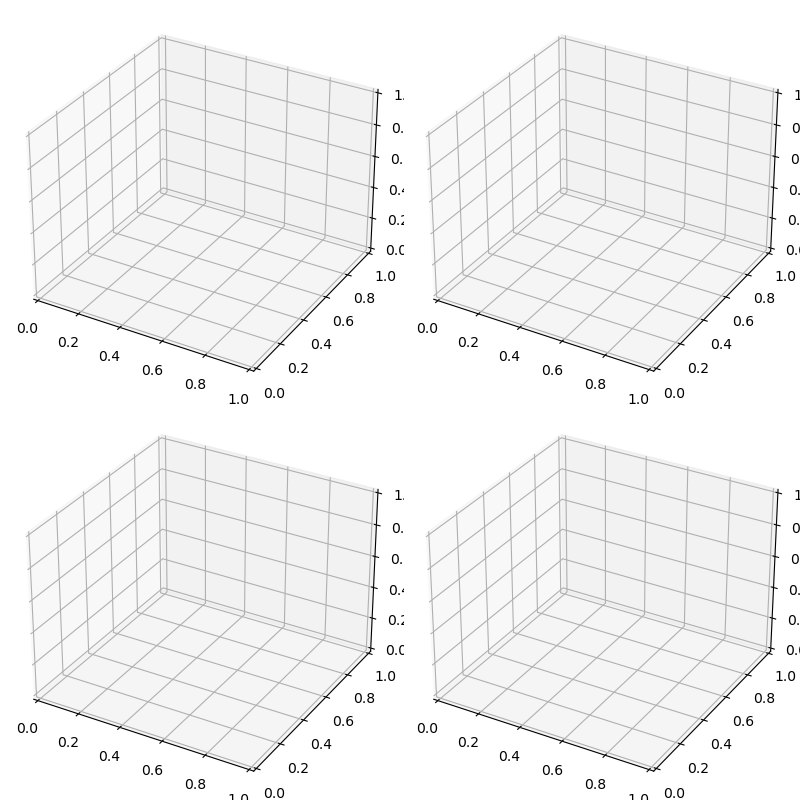

In [2]:
cs = ['#CADBC0', '#C94277']
servs = ['17212', '17371', '17219'] # Serial #s of Vectors
mids = ['C2', 'C4', 'C3'] # Mooring IDs
# Test time period
t0 = pd.Timestamp('2022-07-14 18:00:00')
t1 = pd.Timestamp('2022-07-14 19:00:00')

# Save PCA-rotated velocities in dict
pca_dict = {}
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(8,8), nrows=2, ncols=2, subplot_kw={"projection": "3d"}, 
    constrained_layout=True)
lss = ['-', '--', ':'] # Linestyles for PC 1-3
# Iterate over Vectors, rotate C4 and plot comparison
for i, (mid, serv) in enumerate(zip(mids, servs)):
    # Netcdf dir.
    ncdir = os.path.join(vec_root, mid)
    # List all daily ncfiles
    fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
    # Read current date's file
    datestr = DT.strftime(t0, '%Y%m%d')
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    # Get mean heading, pitch, roll angles
    head_ang = dsv.heading_ang.sel(time=slice(t0,t1))
    head_mean = head_ang.mean(dim='time').item()
    pitch_ang = dsv.pitch_ang.sel(time=slice(t0,t1))
    pitch_mean = pitch_ang.mean(dim='time').item()
    roll_ang = dsv.roll_ang.sel(time=slice(t0,t1))
    roll_mean = roll_ang.mean(dim='time').item()
#     if mid == 'C4':
    # Get horizontal and vertical x,y,z velocities
    ux = dsv.uxd.sel(time=slice(t0, t1))
    uy = dsv.uyd.sel(time=slice(t0, t1))
    uz = dsv.uzd.sel(time=slice(t0, t1))
    # Rotate velocities based on principal axes
    vel_pca, R, eul = rpct.rotate_pca(ux=ux.values, uy=uy.values, uz=uz.values,
                                      return_r=True, return_eul=True)
#     elif mid == 'C2':
#         ur = dsv.ucs.sel(time=slice(t0, t1))
#         vr = dsv.uls.sel(time=slice(t0, t1))
#         wr = dsv.uU.sel(time=slice(t0, t1))
#     # Get principal components
#     pca = PCA(n_components=3)
#     pca.fit(np.vstack([ux, uy, uz]).T)
#     # Get eigenvectors (ie rotation matrix R)
#     R = pca.components_
#     # Get Euler angles from R, see
#     # https://www.meccanismocomplesso.org/en/3d-rotations-and-euler-angles-in-python/
# #     eul1 = np.arctan2(R.item(1,0),R.item(0,0)) # roll, rot. about x-axis
# #     sp = np.sin(eul1)
# #     cp = np.cos(eul1)
# #     eul2 = np.arctan2(-R.item(2,0),cp*R.item(0,0)+sp*R.item(1,0)) # pitch, rot. ab. y-axis
# #     eul3 = np.arctan2(sp*R.item(0,2)-cp*R.item(1,2),cp*R.item(1,1)-sp*R.item(0,1)) # head., rot. ab. z-ax.
#     eul1 = -np.arcsin(R[2,0]) # Pitch
#     eul2 = np.arctan2(R[2,1], R[2,2]) # Roll
#     eul3 = np.arctan2(R[1,0]/np.cos(eul2), R[0,0]/np.cos(eul2)) # Heading
  
    print('{} PCA: roll={:.2f}, pitch={:.2f}, head={:.2f}'.format(
        mid, np.rad2deg(eul['eul2']), np.rad2deg(eul['eul1']), np.rad2deg(eul['eul3'])))
    print('{} Vec: roll={:.2f}, pitch={:.2f}, head={:.2f}'.format(mid, roll_mean, pitch_mean, head_mean))


    # Rotate velocities to ENU and plot on bottom row
#     vel_arr = np.array([ux.values, uy.values, uz.values]).T
#     pitch_arr = np.ones_like(ux.values) * np.rad2deg(eul1)
#     roll_arr = np.ones_like(ux.values) * np.rad2deg(eul2)
#     enu = rpct.uvw2enu(vel=vel_arr, heading=head_ang, pitch=pitch_arr, roll=roll_arr, 
#                        magdec=12.88)
#     uE = enu[0,:].copy()
#     uN = enu[1,:].copy()
#     uU = enu[2,:].copy()
    # Rotate velocities along principal axes
#     vel_pca = R.dot(vel_arr.T).T
    up1 = vel_pca[:,0].copy()
    up2 = vel_pca[:,1].copy()
    up3 = vel_pca[:,2].copy()
    # Save to dict
    pca_dict['up1_{}'.format(mid)] = up1
    pca_dict['up2_{}'.format(mid)] = up2
    pca_dict['up3_{}'.format(mid)] = up3

    if mid in ['C2', 'C4']:
        # Plot unrotated points on first row
        axes[0,i].scatter(ux, uy, uz, s=2, color='C0', alpha=0.1)
        # Plot principal axes
        # for ic, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        for ic, comp in enumerate(R):
            axes[0,i].plot([0, comp[0]],
                        [0, comp[1]],
                        [0, comp[2]],
                        label=f"PC {ic+1}",
                        linewidth=2,
                        linestyle=lss[ic],
                        color='k',
                        )
        axes[0,i].set_title('{} xyz'.format(mid))
        axes[0,i].set_xlabel(r'$u_x$')
        axes[0,i].set_ylabel(r'$u_y$')
        axes[0,i].set_zlabel(r'$u_z$')
        axes[0,i].legend(fontsize=8)
        # Rotated PCA points on second row
        axes[1,i].scatter(up1, up2, up3, s=2, color='C1', alpha=0.1)
        axes[1,i].set_title('{} PCA-rotated'.format(mid))
        axes[1,i].set_xlabel(r'$u$ (PC1)')
        axes[1,i].set_ylabel(r'$u$ (PC2)')
        axes[1,i].set_zlabel(r'$u$ (PC3)')

# Axis limits
for ax in axes.flat:
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    ax.set_zlim([-1,1])

plt.tight_layout()
plt.show()
# plt.close()



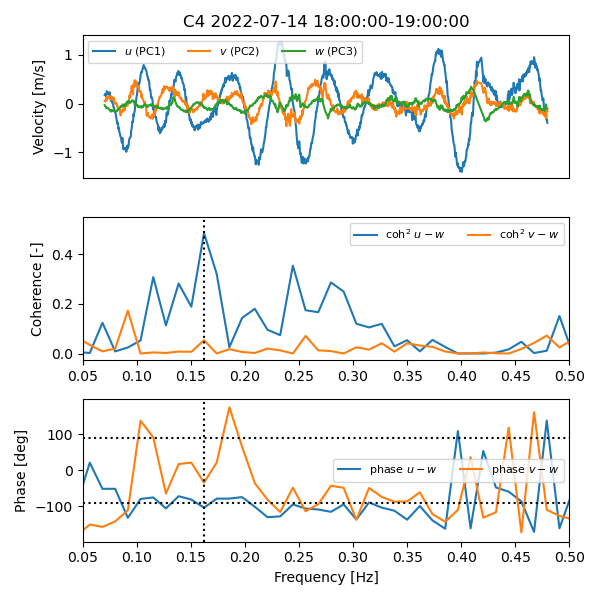

In [152]:
lss = ['-', '--']
mid = 'C4'
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(6,6), nrows=3, sharex=False)
# Iterate over Vectors, rotate C4 and plot comparison
# Plot segments of velocity time series on top row
axes[0].plot(pca_dict['up1_{}'.format(mid)][:1000], color='C0', 
             label=r'$u$ (PC1)')
axes[0].plot(pca_dict['up2_{}'.format(mid)][:1000], color='C1',
             label=r'$v$ (PC2)')
axes[0].plot(pca_dict['up3_{}'.format(mid)][:1000], color='C2',
             label=r'$w$ (PC3)')
axes[0].set_xlabel(None)
axes[0].get_xaxis().set_visible(False)
# Coh. and phase are included in spectral dataset from rpws.spec_uvz()
spec_r = rpws.spec_uvz(z=pca_dict['up3_{}'.format(mid)], 
                       u=pca_dict['up1_{}'.format(mid)], 
                       v=pca_dict['up2_{}'.format(mid)], 
                       fs=16)
# Plot squared coherence as func of freq in middle row
(spec_r.coh_uz**2).plot(ax=axes[1], label=r'$\mathrm{coh}^2$ $u-w$', 
                        color='C0')
(spec_r.coh_vz**2).plot(ax=axes[1], label=r'$\mathrm{coh}^2$ $v-w$', 
                        color='C1')
# Plot phase as func of freq on second row
np.rad2deg(spec_r.ph_uz).plot(ax=axes[2], label=r'phase $u-w$', color='C0')
np.rad2deg(spec_r.ph_vz).plot(ax=axes[2], label=r'phase $v-w$', color='C1')
# Horizontal lines at phase = +/-90
axes[2].axhline(90, linestyle=':', color='k')
axes[2].axhline(-90, linestyle=':', color='k')
# Vertical line at max u-w coherence
ind_mc = np.argmax((spec_r.coh_uz**2).values)
axes[1].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')
axes[2].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')

# Axis limits etc
for ax in axes[1:]:
    ax.set_xlim([0.05, 0.5])
    ax.set_xlabel(None)
for ax in axes:
    ax.set_ylabel(None)
    ax.legend(fontsize=8, ncols=3)
axes[0].set_title('{} {}-{}'.format(mid, t0, t1.time()))
axes[2].set_xlabel('Frequency [Hz]')
axes[2].set_xlabel('Frequency [Hz]')
axes[0].set_ylabel('Velocity [m/s]')
axes[1].set_ylabel('Coherence [-]')
axes[2].set_ylabel('Phase [deg]')

plt.tight_layout()
plt.show()

In [159]:
assert(np.allclose(np.linalg.det(R), 1))
ux.values.shape
vel_pca.shape

(19200, 3)

In [139]:
pca_dict

{'up1_C2': array([-0.02794028, -0.07188935, -0.16486033, ...,  0.06368313,
         0.06082235,  0.11148385]),
 'up2_C2': array([0.13692965, 0.06562984, 0.11149676, ..., 0.25318307, 0.17672373,
        0.0614292 ]),
 'up3_C2': array([-0.10911742, -0.13429313, -0.13982683, ..., -0.08546806,
        -0.10480156, -0.12815929]),
 'up1_C4': array([ 0.17649386,  0.19910617,  0.16724777, ..., -0.36679096,
        -0.28711352, -0.24159683]),
 'up2_C4': array([ 0.05732211,  0.06428024,  0.04195723, ..., -0.05777776,
        -0.08784913, -0.08496627]),
 'up3_C4': array([-0.0317505 , -0.05563078, -0.06169095, ...,  0.19589314,
         0.19339948,  0.2126328 ])}

Test rotation with Vector at C4, compare results agains Vector at C2 (good data).

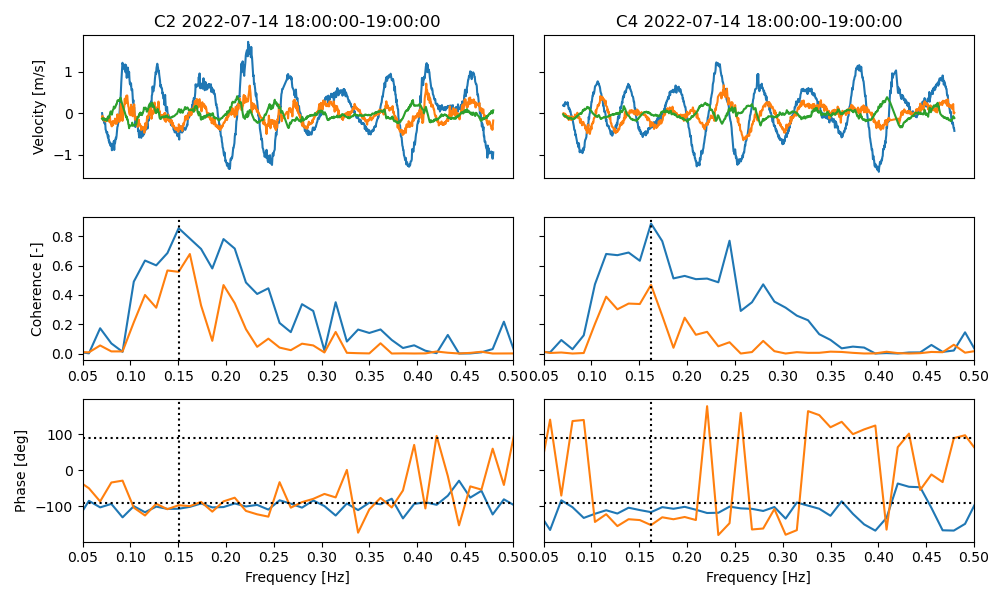

In [136]:
cs = ['#CADBC0', '#C94277']
servs = ['17212', '17371'] # Serial #s of Vectors
mids = ['C2', 'C4'] # Mooring IDs
# Test time period
t0 = pd.Timestamp('2022-07-14 18:00:00')
t1 = pd.Timestamp('2022-07-14 19:00:00')

lss = ['-', '--']
# Initialize comparison figure
fig, axes = plt.subplots(figsize=(10,6), nrows=3, ncols=2, sharey='row', sharex=False)
# Iterate over Vectors, rotate C4 and plot comparison
for i, (mid, serv) in enumerate(zip(mids, servs)):
    # Netcdf dir.
    ncdir = os.path.join(vec_root, mid)
    # List all daily ncfiles
    fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
    # Read current date's file
    datestr = DT.strftime(t0, '%Y%m%d')
    fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
    dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
    if mid == 'C4':
        # Get horizontal and vertical x,y,z velocities
        ur = dsv.uxd.sel(time=slice(t0, t1))
        vr = dsv.uyd.sel(time=slice(t0, t1))
        wr = dsv.uzd.sel(time=slice(t0, t1))
        # Rotate velocities based on covariance
    elif mid == 'C2':
        ur = dsv.ucs.sel(time=slice(t0, t1))
        vr = dsv.uls.sel(time=slice(t0, t1))
        wr = dsv.uU.sel(time=slice(t0, t1))

    # Plot segments of velocity time series on top row
    ur.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C0')
    vr.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C1')
    wr.isel(time=slice(0, 1000)).plot(ax=axes[0,i], color='C2')
    axes[0,i].set_xlabel(None)
    axes[0,i].get_xaxis().set_visible(False)
    # Coh. and phase are included in spectral dataset from rpws.spec_uvz()
    spec_r = rpws.spec_uvz(z=wr.values, u=ur.values, v=vr.values, fs=16)
    # Plot squared coherence as func of freq in middle row
    (spec_r.coh_uz**2).plot(ax=axes[1,i], label='coh_uw**2', color='C0')
    (spec_r.coh_vz**2).plot(ax=axes[1,i], label='coh_vw**2', color='C1')
    # Plot phase as func of freq on second row
    np.rad2deg(spec_r.ph_uz).plot(ax=axes[2,i], label='ph_uw', color='C0')
    np.rad2deg(spec_r.ph_vz).plot(ax=axes[2,i], label='ph_vw', color='C1')
    # Horizontal lines at phase = +/-90
    axes[2,i].axhline(90, linestyle=':', color='k')
    axes[2,i].axhline(-90, linestyle=':', color='k')
    # Vertical line at max u-w coherence
    ind_mc = np.argmax((spec_r.coh_uz**2).values)
    axes[1,i].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')
    axes[2,i].axvline(spec_r.freq.values[ind_mc], color='k', linestyle=':')


# Axis limits etc
for ax in axes[1:,:].flat:
    ax.set_xlim([0.05, 0.5])
    ax.set_xlabel(None)
for ax in axes[:,1].flat:
    ax.set_ylabel(None)
axes[0,0].set_title('C2 {}-{}'.format(t0, t1.time()))
axes[0,1].set_title('C4 {}-{}'.format(t0, t1.time()))


axes[2,0].set_xlabel('Frequency [Hz]')
axes[2,1].set_xlabel('Frequency [Hz]')
axes[0,0].set_ylabel('Velocity [m/s]')
axes[1,0].set_ylabel('Coherence [-]')
axes[2,0].set_ylabel('Phase [deg]')

plt.tight_layout()
plt.show()
# plt.close()





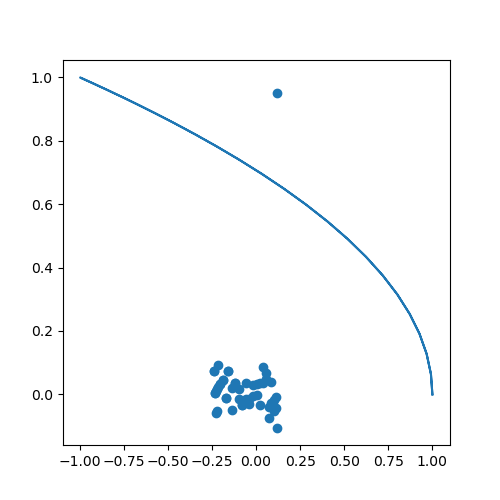

In [45]:
# Test
from sklearn.decomposition import PCA
x = np.linspace(0, 2*np.pi)
y = np.cos(x)
z = np.sin(x/2)

pca = PCA(n_components=2)
pca.fit(np.vstack([y,z]))
# print(pca.components_)

fig, ax = plt.subplots(figsize=(5,5))
ax.plot(y,z)
ax.scatter(pca.components_[0], pca.components_[1])



